In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [35]:
# Dataset class for csv MNIST
class MNISTCSVDataset(Dataset):
    def __init__(self,csv_file):
        data=pd.read_csv(csv_file)
        self.labels=torch.tensor(data.iloc[:,0].values,dtype=torch.long)
        self.images=torch.tensor(data.iloc[:,1:].values,dtype=torch.float32)/255.0
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        return self.images[idx],self.labels[idx]


In [36]:
# data loading
train_dataset=MNISTCSVDataset("mnist_train.csv")
test_dataset=MNISTCSVDataset("mnist_test.csv")
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)


In [37]:
# FCNN Model
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN,self).__init__()
        self.fc1=nn.Linear(784,128)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(128,10)
    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.relu(self.fc1(x))
        x=self.fc2(x)
        return x


In [38]:
# Our training fxn;
def train_model(model,loader,epochs=20):
    model.to(device)
    model.train()
    optimizer=optim.Adam(model.parameters(),lr=0.001)
    criterion=nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss=0
        for imgs,labels in loader:
            imgs,labels=imgs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(imgs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}")


In [39]:
# Evaluation function
def evaluate(model,loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for imgs,labels in loader:
            imgs,labels=imgs.to(device),labels.to(device)
            preds=model(imgs).argmax(1)
            correct+=(preds==labels).sum().item()
            total+=labels.size(0)
    return correct/total


In [40]:
# Part 2.1: training on normal mnist

normal_model=FCNN()
train_model(normal_model,train_loader)
normal_acc=evaluate(normal_model,test_loader)
print(f"\nNormal MNIST Accuracy: {normal_acc*100:.2f}%")


Epoch 1, Loss: 0.3391
Epoch 2, Loss: 0.1538
Epoch 3, Loss: 0.1082
Epoch 4, Loss: 0.0809
Epoch 5, Loss: 0.0638
Epoch 6, Loss: 0.0516
Epoch 7, Loss: 0.0416
Epoch 8, Loss: 0.0337
Epoch 9, Loss: 0.0277
Epoch 10, Loss: 0.0228
Epoch 11, Loss: 0.0187
Epoch 12, Loss: 0.0169
Epoch 13, Loss: 0.0122
Epoch 14, Loss: 0.0121
Epoch 15, Loss: 0.0097
Epoch 16, Loss: 0.0076
Epoch 17, Loss: 0.0084
Epoch 18, Loss: 0.0060
Epoch 19, Loss: 0.0053
Epoch 20, Loss: 0.0053

Normal MNIST Accuracy: 97.99%


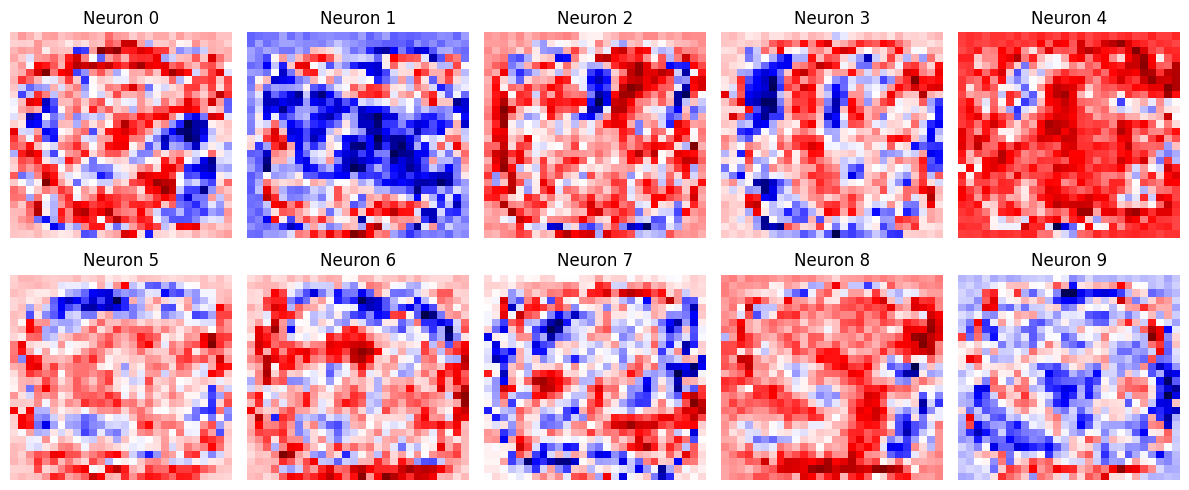

In [41]:
# weight visualization(part of q2.1)
normal_model.eval()
weights=normal_model.fc1.weight.data.cpu()
fig,axes=plt.subplots(2,5,figsize=(12,5))
for i,ax in enumerate(axes.flat):
    w=weights[i].reshape(28,28)
    w=(w-w.mean())/(w.std()+1e-5)
    sns.heatmap(w,cmap="seismic",ax=ax,cbar=False)
    ax.set_title(f"Neuron {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [42]:
# 2.2 scrambled mnist Dataset

In [43]:
perm=torch.randperm(784)
class ScrambledMNIST(Dataset):
    def __init__(self,base_dataset,perm):
        self.base=base_dataset
        self.perm=perm
    def __len__(self):
        return len(self.base)
    def __getitem__(self,idx):
        img,label=self.base[idx]
        img=img[self.perm]
        return img,label


In [44]:
# test on scrambled mnist
scrambled_train=ScrambledMNIST(train_dataset,perm)
scrambled_test=ScrambledMNIST(test_dataset,perm)
scrambled_train_loader=DataLoader(scrambled_train,batch_size=64,shuffle=True)
scrambled_test_loader=DataLoader(scrambled_test,batch_size=64,shuffle=False)


In [ ]:
# train on scramble mnist
scrambled_model=FCNN()
train_model(scrambled_model,scrambled_train_loader)
scrambled_acc=evaluate(scrambled_model,scrambled_test_loader)
print(f"\nScrambled MNIST Accuracy: {scrambled_acc*100:.2f}%")


Epoch 1, Loss: 0.3413
Epoch 2, Loss: 0.1561
Epoch 3, Loss: 0.1096
Epoch 4, Loss: 0.0839
Epoch 5, Loss: 0.0671
Epoch 6, Loss: 0.0549
Epoch 7, Loss: 0.0443
Epoch 8, Loss: 0.0366
Epoch 9, Loss: 0.0308
Epoch 10, Loss: 0.0253
Epoch 11, Loss: 0.0197
Epoch 12, Loss: 0.0187
Epoch 13, Loss: 0.0135
Epoch 14, Loss: 0.0123
Epoch 15, Loss: 0.0100
